# Deconfounder on Jobs Data
Deconfounder tutorial: https://colab.research.google.com/github/blei-lab/deconfounder_tutorial/blob/master/deconfounder_tutorial.ipynb#scrollTo=tYjfPtOW_zmc

Jobs Data: https://users.nber.org/~rdehejia/data/.nswdata2.html

## Setup

In [72]:
!pip install tensorflow_probability

In [73]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, mean_squared_error, r2_score

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)

In [74]:
# set random seed so everyone gets the same number
import random
randseed = 123
print("random seed: ", randseed)
random.seed(randseed)
np.random.seed(randseed)
tf.set_random_seed(randseed)

random seed:  123


## Clean Jobs Data

Convert txt files to useable csv

The order of the variables from left to right is: treatment indicator (1 if treated, 0 if not treated), age, education, Black (1 if black, 0 otherwise), Hispanic (1 if Hispanic, 0 otherwise), married (1 if married, 0 otherwise), nodegree (1 if no degree, 0 otherwise), RE75 (earnings in 1975), and RE78 (earnings in 1978). The last variable is the outcome; other variables are pre-treatment.



In [75]:
def data_to_csv(txt_path, csv_path):
  #convert text files to cleaned csv
  columns = ['treatment','age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're75', 're78']
  control = pd.read_csv(txt_path, delimiter = '  ', header= None)
  control.columns = columns
  control.to_csv (csv_path, index=None)
  return control


In [76]:
columns = ['treatment','age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're75', 're78']
control = data_to_csv('/content/nsw_control.txt', '/content/control.csv')
treated = data_to_csv('/content/nsw_treated.txt', '/content/treated.csv')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [77]:
# merge treatment and control
data = pd.concat([treated, control], ignore_index = True)
data

,treatment,age,education,black,hispanic,married,nodegree,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0000,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0000,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0000,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0000,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0000,289.7899
...,...,...,...,...,...,...,...,...,...
717,0.0,20.0,10.0,1.0,0.0,0.0,1.0,825.2301,0.0000
718,0.0,17.0,9.0,0.0,1.0,0.0,1.0,0.0000,5114.8140
719,0.0,17.0,9.0,1.0,0.0,0.0,1.0,1206.4410,0.0000
720,0.0,19.0,11.0,1.0,0.0,0.0,1.0,0.0000,0.0000


In [78]:
#get x and y
df = data[columns[:-1]]
dfy = data["re78"]
df

,treatment,age,education,black,hispanic,married,nodegree,re75
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0000
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0000
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0000
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0000
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0000
...,...,...,...,...,...,...,...,...
717,0.0,20.0,10.0,1.0,0.0,0.0,1.0,825.2301
718,0.0,17.0,9.0,0.0,1.0,0.0,1.0,0.0000
719,0.0,17.0,9.0,1.0,0.0,0.0,1.0,1206.4410
720,0.0,19.0,11.0,1.0,0.0,0.0,1.0,0.0000


## Prepare Dataset for deconfounder

Get rid oh highly correlated causes

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


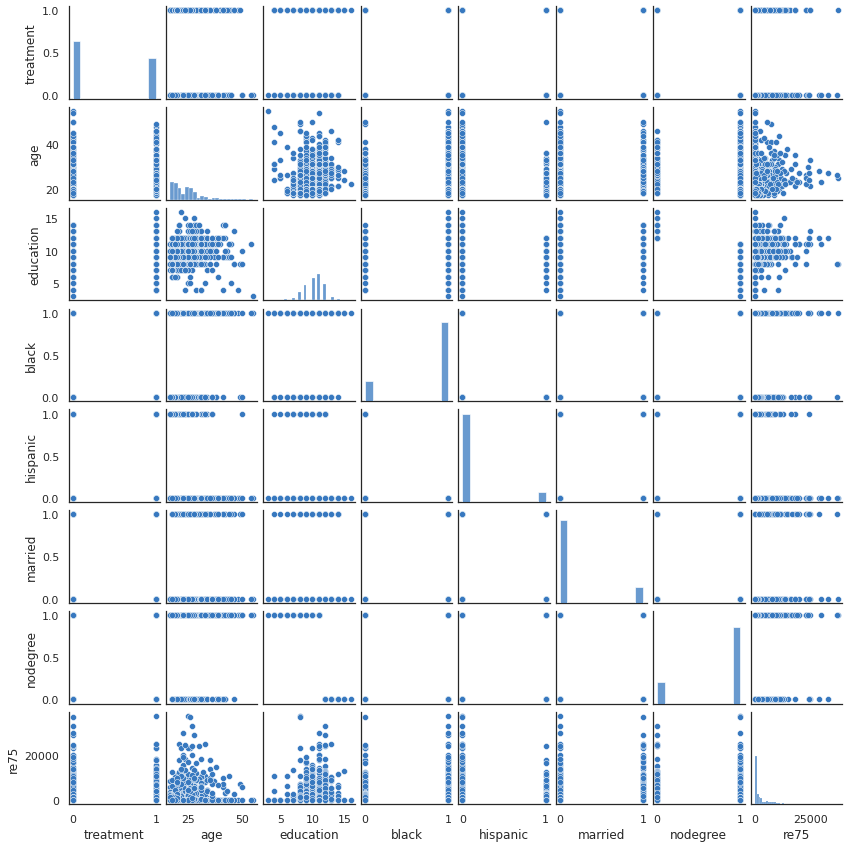

In [ ]:

sns.pairplot(df, size=1.5)

No correlation between non-binary variables. Checking correlation between binary variables.

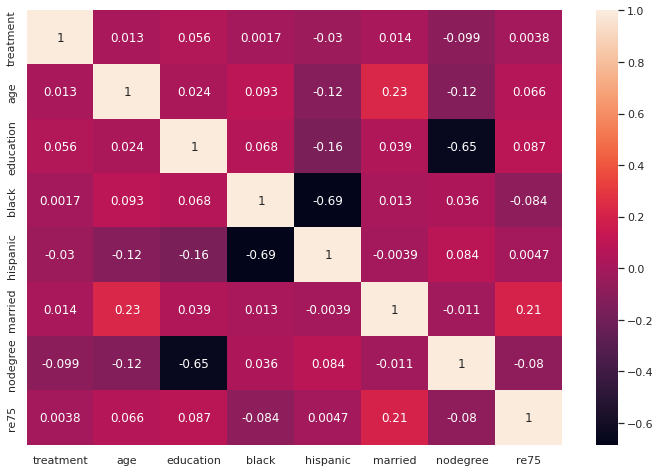

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)

High negative correlation between nodegree and education (intuitive), as well as ethnicities of Black and hispanics (interesting). Removing nodegree and hispanic

In [79]:
# nodegree/hispanic are highly correlated with education/black
fea_cols = df.columns[[(not df.columns[i].endswith("nodegree")) \
                     and (not df.columns[i].endswith("hispanic")) \
                     and (not df.columns[i].endswith("re75")) \
                     for i in range(df.shape[1])]]

In [80]:
dfX = pd.DataFrame(df[fea_cols])
print(dfX.shape, dfy.shape)

(722, 5) (722,)


In [81]:
dfX.head()

,treatment,age,education,black,married
0,1.0,37.0,11.0,1.0,1.0
1,1.0,22.0,9.0,0.0,0.0
2,1.0,30.0,12.0,1.0,0.0
3,1.0,27.0,11.0,1.0,0.0
4,1.0,33.0,8.0,1.0,0.0


In [82]:
dfy[:5]

0     9930.0460
1     3595.8940
2    24909.4500
3     7506.1460
4      289.7899
Name: re78, dtype: float64

## Causal Inference with Deconfounder

Optional: Normalize data

In [83]:
# standardize the data for PPCA
#X = np.array((dfX - dfX.mean())/dfX.std())

X = np.array(dfX)

In [84]:
# uncomment if removing features- check without removing hispanic etc
#dfX = df

In [85]:
# randomly holdout some entries of X
num_datapoints, data_dim = X.shape

holdout_portion = 0.2
n_holdout = int(holdout_portion * num_datapoints * data_dim)

holdout_row = np.random.randint(num_datapoints, size=n_holdout)
holdout_col = np.random.randint(data_dim, size=n_holdout)
holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                            (holdout_row, holdout_col)), \
                            shape = X.shape)).toarray()

holdout_subjects = np.unique(holdout_row)
holdout_mask = np.minimum(1, holdout_mask)

x_train = np.multiply(1-holdout_mask, X)
x_vad = np.multiply(holdout_mask, X)

In [62]:
print(holdout_mask)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1.]]


In [63]:
x_train

array([[ 1.,  0., 11.,  1.,  1.],
       [ 1.,  0.,  9.,  0.,  0.],
       [ 0., 30., 12.,  1.,  0.],
       ...,
       [ 0.,  0.,  9.,  1.,  0.],
       [ 0., 19.,  0.,  0.,  0.],
       [ 0., 18., 10.,  1.,  0.]])

In [64]:
x_vad

array([[ 0., 37.,  0.,  0.,  0.],
       [ 0., 22.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       ...,
       [ 0., 17.,  0.,  0.,  0.],
       [ 0.,  0., 11.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [65]:
X

array([[ 1., 37., 11.,  1.,  1.],
       [ 1., 22.,  9.,  0.,  0.],
       [ 1., 30., 12.,  1.,  0.],
       ...,
       [ 0., 17.,  9.,  1.,  0.],
       [ 0., 19., 11.,  1.,  0.],
       [ 0., 18., 10.,  1.,  0.]])

### Probabilistic PCA

In [93]:
# we allow both linear and quadratic model
# for linear model x_n has mean z_n * W
# for quadratic model x_n has mean b + z_n * W + (z_n**2) * W_2
# quadractice model needs to change the checking step accordingly

def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, mask, form="linear"):
    w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                scale=tf.ones([num_datapoints, latent_dim]), 
                name="z")  # local latent variable / substitute confounder
    if form == "linear":
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
    elif form == "quadratic":
        b = ed.Normal(loc=tf.zeros([1, data_dim]),
                scale=tf.ones([1, data_dim]),
                name="b")  # intercept
        w2 = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w2")  # quadratic parameter
        x = ed.Normal(loc=tf.multiply(b + tf.matmul(z, w) + tf.matmul(tf.square(z), w2), mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
    return x, (w, z)

log_joint = ed.make_log_joint_fn(ppca_model)

In [95]:
# fitting PPCA

latent_dim = 2
stddv_datapoints = 0.1

model = ppca_model(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints, 
                   mask=1-holdout_mask,
                   #change form according to experiment
                   form = "quadratic")

Inferred axes:
[[-0.17569487  3.9849792   0.9003073  -0.0785149   0.04498047]
 [ 0.27018443  3.8629184   2.142631    0.32877022 -0.00802277]]
Standard Deviation:
[[0.00385957 0.01053298 0.00927001 0.00327527 0.00500426]
 [0.00382181 0.00882404 0.00913417 0.00395825 0.00463946]]


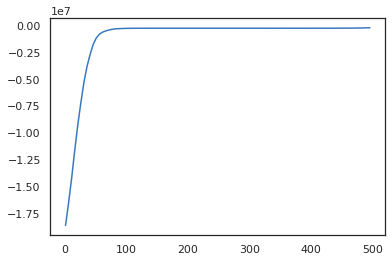

In [96]:
def variational_model(qb_mean, qb_stddv, qw_mean, qw_stddv, 
                      qw2_mean, qw2_stddv, qz_mean, qz_stddv):
    qb = ed.Normal(loc=qb_mean, scale=qb_stddv, name="qb")
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qw2 = ed.Normal(loc=qw2_mean, scale=qw2_stddv, name="qw2")
    qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
    return qb, qw, qw2, qz


log_q = ed.make_log_joint_fn(variational_model)

def target(b, w, w2, z):
    """Unnormalized target density as a function of the parameters."""
    return log_joint(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints,
                   mask=1-holdout_mask,
                   w=w, z=z, w2=w2, b=b, x=x_train)

def target_q(qb, qw, qw2, qz):
    return log_q(qb_mean=qb_mean, qb_stddv=qb_stddv,
                 qw_mean=qw_mean, qw_stddv=qw_stddv,
                 qw2_mean=qw2_mean, qw2_stddv=qw2_stddv,
                 qz_mean=qz_mean, qz_stddv=qz_stddv,
                 qw=qw, qz=qz, qw2=qw2, qb=qb)

qb_mean = tf.Variable(np.ones([1, data_dim]), dtype=tf.float32)
qw_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
qw2_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([num_datapoints, latent_dim]), dtype=tf.float32)
qb_stddv = tf.nn.softplus(tf.Variable(0 * np.ones([1, data_dim]), dtype=tf.float32))
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
qw2_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

qb, qw, qw2, qz = variational_model(qb_mean=qb_mean, qb_stddv=qb_stddv,
                                    qw_mean=qw_mean, qw_stddv=qw_stddv,
                                    qw2_mean=qw2_mean, qw2_stddv=qw2_stddv,
                                    qz_mean=qz_mean, qz_stddv=qz_stddv)


energy = target(qb, qw, qw2, qz)
entropy = -target_q(qb, qw, qw2, qz)

elbo = energy + entropy


optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
train = optimizer.minimize(-elbo)

init = tf.global_variables_initializer()

t = []

num_epochs = 500

with tf.Session() as sess:
    sess.run(init)

    for i in range(num_epochs):
        sess.run(train)
        if i % 5 == 0:
            t.append(sess.run([elbo]))

        b_mean_inferred = sess.run(qb_mean)
        b_stddv_inferred = sess.run(qb_stddv)
        w_mean_inferred = sess.run(qw_mean)
        w_stddv_inferred = sess.run(qw_stddv)
        w2_mean_inferred = sess.run(qw2_mean)
        w2_stddv_inferred = sess.run(qw2_stddv)
        z_mean_inferred = sess.run(qz_mean)
        z_stddv_inferred = sess.run(qz_stddv)
        
print("Inferred axes:")
print(w_mean_inferred)
print("Standard Deviation:")
print(w_stddv_inferred)

plt.plot(range(1, num_epochs, 5), t)
plt.show()

def replace_latents(b, w, w2, z):

    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "b":
            rv_kwargs["value"] = b
        elif name == "w":
            rv_kwargs["value"] = w
        elif name == "w":
            rv_kwargs["value"] = w2
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)

    return interceptor

### Check Factor Model

In [97]:
n_rep = 100 # number of replicated datasets we generate
holdout_gen = np.zeros((n_rep,*(x_train.shape)))

for i in range(n_rep):
    b_sample = npr.normal(b_mean_inferred, b_stddv_inferred)
    w_sample = npr.normal(w_mean_inferred, w_stddv_inferred)
    w2_sample = npr.normal(w2_mean_inferred, w2_stddv_inferred)
    z_sample = npr.normal(z_mean_inferred, z_stddv_inferred)

    with ed.interception(replace_latents(b_sample, w_sample, w2_sample, z_sample)):
        generate = ppca_model(
            data_dim=data_dim, latent_dim=latent_dim,
            num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints,
            mask=np.ones(x_train.shape),
            #change according to experiment
            form = "quadratic")

    with tf.Session() as sess:
        x_generated, _ = sess.run(generate)

    # look only at the heldout entries
    holdout_gen[i] = np.multiply(x_generated, holdout_mask)

In [100]:
n_eval = 100 # we draw samples from the inferred Z and W
obs_ll = []
rep_ll = []

#change if quadratic
linear = False

for j in range(n_eval):
  if linear:
    w_sample = npr.normal(w_mean_inferred, w_stddv_inferred)
    z_sample = npr.normal(z_mean_inferred, z_stddv_inferred)

    holdoutmean_sample = np.multiply(z_sample.dot(w_sample), holdout_mask)

  else:
    b_sample = npr.normal(b_mean_inferred, b_stddv_inferred)
    w_sample = npr.normal(w_mean_inferred, w_stddv_inferred)
    w2_sample = npr.normal(w2_mean_inferred, w2_stddv_inferred)
    z_sample = npr.normal(z_mean_inferred, z_stddv_inferred)

    holdoutmean_sample = np.multiply(b_sample + z_sample.dot(w_sample) + np.square(z_sample).dot(w2_sample), holdout_mask)



  obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                        stddv_datapoints).logpdf(x_vad), axis=1))

  rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                        stddv_datapoints).logpdf(holdout_gen),axis=2))
    
obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)





In [101]:
pvals = np.array([np.mean(rep_ll_per_zi[:,i] < obs_ll_per_zi[i]) for i in range(num_datapoints)])
holdout_subjects = np.unique(holdout_row)
overall_pval = np.mean(pvals[holdout_subjects])
print("Predictive check p-values", overall_pval)

Predictive check p-values 0.6048008849557522


### Correct for substitute confounder

In [102]:
# approximate the (random variable) substitute confounders with their inferred mean.
Z_hat = z_mean_inferred 
# augment the regressors to be both the assigned causes X and the substitute confounder Z
X_aug = np.column_stack([X, Z_hat])

In [103]:
# holdout some data from prediction later
X_train, X_test, y_train, y_test = train_test_split(X_aug, dfy, test_size=0.2, random_state=0)

In [104]:
dcfX_train = sm.add_constant(X_train)

## change logit from referrence to OLS for regressin (instead of classification)
# dcflogit_model = sm.Logit(y_train, dcfX_train)
# dcfresult = dcflogit_model.fit_regularized(maxiter=5000)

dcfOLS_model = sm.OLS(y_train, dcfX_train)
dcfresult = dcfOLS_model.fit()
print(dcfresult.summary())
# dcfresult = dcfOLS_model.fit_regularized(maxiter=5000)

#summary when regularized is null for some reason, print params : https://github.com/statsmodels/statsmodels/issues/3670
#print(dcfresult.params)



                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.617
Date:                Mon, 11 Apr 2022   Prob (F-statistic):             0.0115
Time:                        22:21:56   Log-Likelihood:                -5862.2
No. Observations:                 577   AIC:                         1.174e+04
Df Residuals:                     569   BIC:                         1.178e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3337.3501   1935.410      1.724      0.0

In [105]:
#correct tutorials dfresult.conv_int

res = pd.DataFrame({"causal_mean": dcfresult.params[:data_dim+1], \
                    "causal_std": dcfresult.bse[:data_dim+1], \
                    "causal_025": dcfresult.conf_int()[:data_dim+1][0], \
                    "causal_975": dcfresult.conf_int()[:data_dim+1][1], \
                   "causal_pval": dcfresult.pvalues[:data_dim+1]
                  })

res["causal_sig"] = (res["causal_pval"] < 0.05)
res = res.T
res.columns = np.concatenate([["intercept"], np.array(dfX.columns)])
res = res.T

In [106]:
res

,causal_mean,causal_std,causal_025,causal_975,causal_pval,causal_sig
intercept,3337.350101,1935.40961,-464.069027,7138.769229,0.085185,False
treatment,1088.929513,559.167847,-9.355489,2187.214515,0.051977,False
age,112.525508,78.693229,-42.039161,267.090177,0.153287,False
education,360.095032,194.419764,-21.772975,741.963039,0.064522,False
black,-1878.982161,670.387565,-3195.718474,-562.245848,0.005238,True
married,789.236151,715.970213,-617.03095,2195.503253,0.270784,False


In [107]:
# make predictions with the causal model 
dcfX_test = X_test
dcfy_pred = dcfresult.predict(sm.add_constant(dcfX_test))
print(r2_score(y_test, dcfy_pred))



-0.0004591281583345985
